# Ensemble learning

In [1]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

import pandas as pd

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:10000]
y = mnist.target[:10000]

## Transformacja zbioru do przestrzeni 30D

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [5]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(10000, 2)

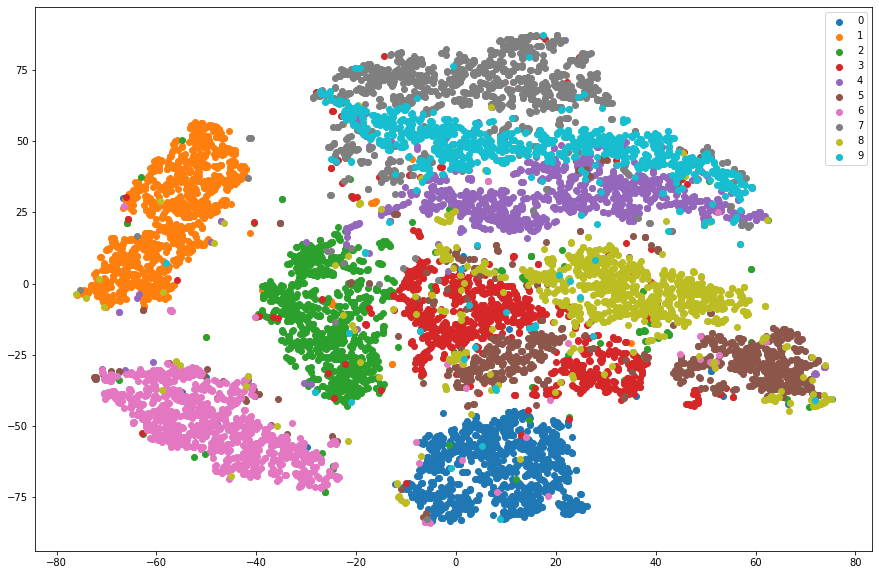

In [7]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [6]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

In [8]:
X_train.shape

(1566, 30)

## Bagging

W zależności od sposobu wyboru podzbiorów zbioru danych wyróżniamy różne rodzaje tego algorytmu:

- **pasting** - wybór losowych podzbiorów próbek
- **bagging** - wybór losowych podzbiorów próbek ze zwracaniem
- **random subspaces** - wybór losowych podzbiorów cech
- **random patches** - wybór losowych podzbiorów próbek i cech

W praktyce wybór metody sprowadza się do odpowiedniego ustawienia zmiennych w klasyfikatorze BaggingClassifier.
Szczegółowy opis można znaleźć w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) sklearn.

#### Klasyczny bagging

Jak zostało wyżej wspomniane - w tej metodzie wybieramy losowo podzbory próbek ze zwracaniem. Jest to domyślny wariant klasyfikatora BaggingClassifier.

In [9]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        max_samples=0.5).fit(X_train, y_train)

In [10]:
clf.score(X_test, y_test)

0.9770408163265306

Metody grupowania są silnie uzależnione od ilości klasyfikatorów oraz ilości próbek, których użyjemy do ich trenowania. Możemy w prosty sposób zwizualizować tą zależność:

In [11]:
def ensemble_scores(clf, estimators, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_samples in samples:
            fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             max_samples=max_samples,
                             n_jobs=-1).fit(X_train, y_train)
            yield n_estimators, max_samples, fitted_clf.score(X_test, y_test)

            
def visualize_ensemble(clf, n_estimators, max_samples, base_estimator=None):
    values = np.array(list(ensemble_scores(clf, n_estimators, max_samples, base_estimator)))
    X = values[:,0]
    Y = values[:,1]
    Z = values[:,2]
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis')

In [12]:
estimators = np.arange(5, 200, 10)
samples = np.linspace(0.1, 1., num=20)

Starting visualisation...


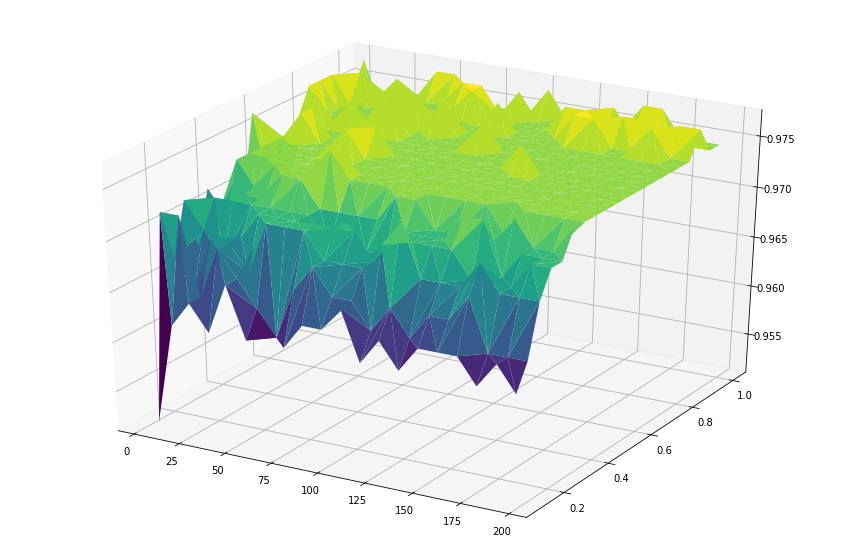

In [18]:
visualize_ensemble(BaggingClassifier, estimators, samples, base_estimator=SVC())

#### Random subspace

Metoda random subspace od zwykłego baggingu różni się tym, że wybieramy podzbiory cech zamiast podzbiorów próbek. Ustawiamy flagi:
- **bootstrap_features=True** - wybieramy cechy ze zwracaniem
- **max_samples=1.0 (default)** - nie losujemy próbek (bierzemy wszystkie)
- **max_features=n** - ilość losowanych cech

In [13]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5).fit(X_train, y_train)

In [14]:
clf.score(X_test, y_test)

0.9489795918367347

#### Random patching

Połączenie powyższych metod nazywamy _random patching_. Ze zbioru losujemy i próbki, i cechy.

In [15]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5,
                        max_samples=0.6).fit(X_train, y_train)

In [16]:
clf.score(X_test, y_test)

0.9591836734693877

### Zadanie
1. Zwizualizuj za pomocą tabeli zależność powyższych metod od *n_estimators* i *max_samples*/*max_features*.
2. Odpowiedz na pytanie: jak zmienia się dokładność klasyfikacji dla różnych metod określana finalnej decyzji (normalna średnia, majority vote, etc.)

In [18]:
def ensemble_samples_acc(clf, n_estimators, max_features, samples, base_estimator=None):
    for max_samples in samples:
        fitted_clf = clf(base_estimator=base_estimator,
                         n_estimators=n_estimators,
                         max_samples=max_samples,
                         max_features=max_features,
                         bootstrap_features=True,
                         random_state=12,
                         n_jobs=-1,
                        ).fit(X_train, y_train)
        yield max_samples, fitted_clf.score(X_test, y_test)

In [2]:
def highlight_max(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [20]:
def get_samples_feats_table(estimators, probability=False):
    features = np.linspace(0.1, 1., num=5)
    samples = np.linspace(0.1, 1., num=5)

    d = []
    ind = []
    

    for max_features in features:
        ind.append("max_feats = " + str(max_features))
        d.append(
            {"samples = " + str(max_samples): acc for (max_samples, acc) in ensemble_samples_acc(BaggingClassifier,
                                                                          estimators,
                                                                          max_features,
                                                                          samples,
                                                                          base_estimator=SVC(probability=probability))})
    
    print("final decision method: ", "average" if probability else "majority vote")
    print("n_estimators = ", estimators)
    df = pd.DataFrame(d, index=ind)
    df = df.style.apply(highlight_max, color='darkorange', axis=None)
    return df

#### Metoda majority vote

In [21]:
get_samples_feats_table(estimators=5)

final decision method:  majority vote
n_estimators =  5


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.704082,0.706633,0.714286,0.724490,0.724490
max_feats = 0.325,0.877551,0.915816,0.913265,0.928571,0.936224
max_feats = 0.55,0.928571,0.936224,0.948980,0.941327,0.948980
max_feats = 0.775,0.928571,0.951531,0.961735,0.964286,0.964286
max_feats = 1.0,0.951531,0.964286,0.959184,0.964286,0.964286


In [22]:
get_samples_feats_table(estimators=30)

final decision method:  majority vote
n_estimators =  30


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.816327,0.834184,0.834184,0.844388,0.844388
max_feats = 0.325,0.923469,0.943878,0.941327,0.943878,0.951531
max_feats = 0.55,0.943878,0.966837,0.966837,0.966837,0.969388
max_feats = 0.775,0.946429,0.971939,0.966837,0.969388,0.974490
max_feats = 1.0,0.956633,0.961735,0.969388,0.969388,0.969388


In [23]:
get_samples_feats_table(estimators=50)

final decision method:  majority vote
n_estimators =  50


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.841837,0.857143,0.854592,0.857143,0.864796
max_feats = 0.325,0.923469,0.936224,0.941327,0.943878,0.951531
max_feats = 0.55,0.946429,0.964286,0.969388,0.974490,0.971939
max_feats = 0.775,0.946429,0.966837,0.974490,0.974490,0.974490
max_feats = 1.0,0.959184,0.966837,0.971939,0.971939,0.971939


#### Metoda average

In [24]:
get_samples_feats_table(estimators=5, probability=True)

final decision method:  average
n_estimators =  5


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.709184,0.727041,0.724490,0.734694,0.734694
max_feats = 0.325,0.877551,0.920918,0.918367,0.923469,0.931122
max_feats = 0.55,0.928571,0.943878,0.943878,0.946429,0.948980
max_feats = 0.775,0.936224,0.954082,0.961735,0.961735,0.961735
max_feats = 1.0,0.948980,0.959184,0.964286,0.966837,0.964286


In [25]:
get_samples_feats_table(estimators=30, probability=True)

final decision method:  average
n_estimators =  30


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.859694,0.859694,0.867347,0.862245,0.869898
max_feats = 0.325,0.931122,0.948980,0.948980,0.951531,0.954082
max_feats = 0.55,0.946429,0.964286,0.966837,0.969388,0.969388
max_feats = 0.775,0.951531,0.964286,0.969388,0.969388,0.969388
max_feats = 1.0,0.954082,0.966837,0.969388,0.971939,0.969388


In [26]:
get_samples_feats_table(estimators=50, probability=True)

final decision method:  average
n_estimators =  50


,samples = 0.1,samples = 0.325,samples = 0.55,samples = 0.775,samples = 1.0
max_feats = 0.1,0.864796,0.880102,0.875000,0.880102,0.887755
max_feats = 0.325,0.926020,0.938776,0.943878,0.956633,0.959184
max_feats = 0.55,0.948980,0.961735,0.966837,0.971939,0.971939
max_feats = 0.775,0.951531,0.966837,0.974490,0.974490,0.974490
max_feats = 1.0,0.956633,0.969388,0.971939,0.974490,0.977041


## Random Forest


Metoda Random Forest różni się od baggingu przede wszystkim tym, że cechy wybierane są losowo spośród wszystkich i najlepszy podział z podzbioru zostaje użyty do dzielenia węzłów w drzewie.
W baggingu natomiast podczas dzielenia węzłów bierze się pod uwagę wszystkie cechy.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) sklearn.

In [27]:
clf = RandomForestClassifier(n_estimators=5,
                             max_samples=0.5).fit(X_train, y_train)

In [28]:
clf.score(X_test, y_test)

0.9158163265306123

## Ada Boost

Metoda, która agreguje wiele słabszych klasyfikatorów w jeden większy. W odróżnieniu od baggingu waga drzew nie jest jednakowa.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier) sklearn.

In [29]:
clf = AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

In [30]:
clf.score(X_test, y_test)

0.8163265306122449

## Projekt indywidualny


Dokonaj analizy zbioru danych FMNIST za pomocą wyżej wymienionych klasyfikatorów.

In [3]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

1. Ze zbioru wybierz dwie trudno rozdzielalne klasy i wykorzystaj je do dalszej analizy.
2. Sprawdź wydajność klasyfikatorów Bagging, RandomForest i AdaBoost dla powstałego zbioru.
3. Dla każdej metody sprawdź zależność wyniku od ilości klasyfikatorów bazowych. Zaprezentuj wyniki w tabelce.
4. Zwizualizuj za pomocą tabeli zależność powyższych metod od n_estimators i max_samples lub max_features (lub obu - w zależności od tego co jest używane w danej metodzie).

### Zadanie 1.

In [5]:
X = fmnist.data[:10000]
y = fmnist.target[:10000]

In [6]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

In [6]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)

In [7]:
X_embedded.shape

(10000, 2)

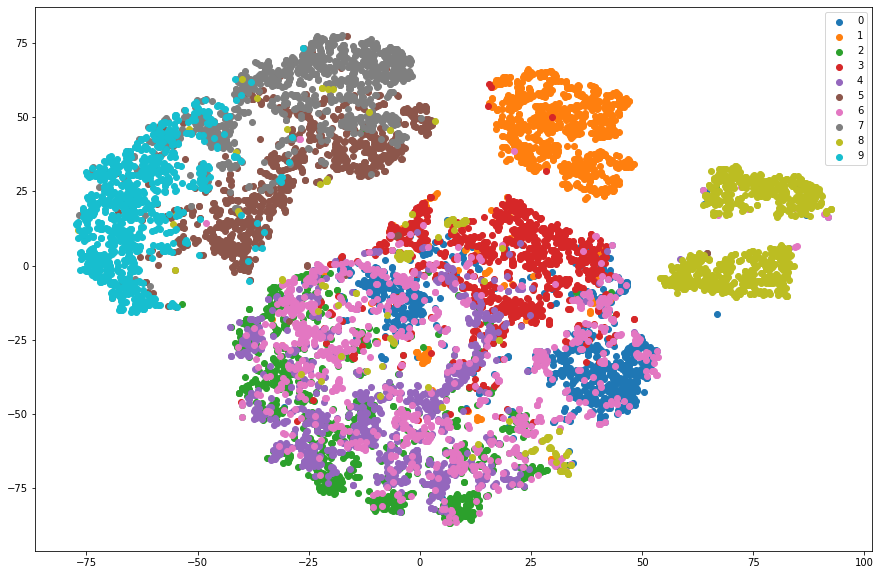

In [8]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Trudno separowalne są klasy 0 i 3.

In [7]:
class_filter = np.where((y == '0') | (y == '3'))
X_filtered, y_filtered = X_pca[class_filter], y[class_filter]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

In [9]:
X_train.shape

(1568, 30)

In [10]:
X_test.shape

(393, 30)

### Zadanie 2, 3, 4.

In [129]:
d = []
ind = []
estimators = [3, 5, 10, 30, 50]

In [130]:
def get_bagging_scores(estimators, max_samples=1.0, max_features=0.55):
    for n_estimators in estimators:
        clf = BaggingClassifier(base_estimator=SVC(probability=True),
                        n_estimators=n_estimators,
                        max_samples=max_samples,
                        bootstrap_features=True,
                        random_state=12,
                        max_features=max_features).fit(X_train, y_train)
        yield n_estimators, clf.score(X_test, y_test)

In [131]:
def get_rf_scores(estimators, max_samples=0.775, max_features=0.325):
    for n_estimators in estimators:
        clf = RandomForestClassifier(n_estimators=n_estimators,
                             max_samples=max_samples,
                             max_features=max_features,
                             random_state=12).fit(X_train, y_train)
        yield n_estimators, clf.score(X_test, y_test)

In [132]:
def get_adaboost_scores(estimators):
    for n_estimators in estimators:
        clf = AdaBoostClassifier(n_estimators=n_estimators).fit(X_train, y_train)
        yield n_estimators, clf.score(X_test, y_test)

In [133]:
d.append({ "n_estimators = " + str(n_estimators): acc for (n_estimators, acc) in get_bagging_scores(estimators)})
ind.append("BaggingClassifier, max_samples=1.0, max_feats=0.55")

In [134]:
d.append({ "n_estimators = " + str(n_estimators): acc for (n_estimators, acc) in get_rf_scores(estimators)})
ind.append("RandomForestClassifier, max_samples=0.775, max_feats=0.325")

In [135]:
d.append({ "n_estimators = " + str(n_estimators): acc for (n_estimators, acc) in get_adaboost_scores(estimators)})
ind.append("AdaBoostClassifier")

In [136]:
df = pd.DataFrame(d, index=ind)
df = df.style.apply(highlight_max, color='darkorange', axis=None)
df

,n_estimators = 3,n_estimators = 5,n_estimators = 10,n_estimators = 30,n_estimators = 50
"BaggingClassifier, max_samples=1.0, max_feats=0.55",0.908397,0.910941,0.908397,0.898219,0.898219
"RandomForestClassifier, max_samples=0.775, max_feats=0.325",0.893130,0.890585,0.895674,0.916031,0.926209
AdaBoostClassifier,0.885496,0.877863,0.888041,0.890585,0.890585


### BaggingClassifier

In [73]:
def ensemble_samples_acc_bagging(clf, n_estimators, max_features, samples, base_estimator=SVC(probability=True)):
#     print("Run Bagging")
    for max_samples in samples:
        fitted_clf = clf(base_estimator=base_estimator,
                         n_estimators=n_estimators,
                         max_samples=max_samples,
                         max_features=max_features,
                         bootstrap_features=True,
                         random_state=12,
                         n_jobs=-1,
                        ).fit(X_train, y_train)
        yield max_samples, fitted_clf.score(X_test, y_test)

In [110]:
def ensemble_samples_acc_rf(clf, n_estimators, max_features, samples):
#     print("Run RF")
    for max_samples in samples:
        if max_samples < 1.0:
            fitted_clf = clf(n_estimators=n_estimators,
                             max_samples=max_samples,
                             max_features=max_features,
                             random_state=12,
                             n_jobs=-1,
                            ).fit(X_train, y_train)
            yield max_samples, fitted_clf.score(X_test, y_test)

In [85]:
def get_samples_feats_table(estimators, classifier):
    features = np.linspace(0.1, 1., num=5)
    samples = np.linspace(0.1, 1., num=5)

    d = []
    ind = []
    
    if issubclass(classifier, BaggingClassifier):
        acc_fun = ensemble_samples_acc_bagging
    else:
        acc_fun = ensemble_samples_acc_rf


    for max_features in features:
        ind.append("max_feats = " + str(max_features))
        d.append(
            {"max_samples = " + str(max_samples): acc for (max_samples, acc) in acc_fun(classifier,
                                                                          estimators,
                                                                          max_features,
                                                                          samples)})
    
    print("BaggingClassifier" if issubclass(classifier, BaggingClassifier) else "RandomForestClassifier")
    print("n_estimators = ", estimators)
    df = pd.DataFrame(d, index=ind)
    df = df.style.apply(highlight_max, color='darkorange', axis=None)
    return df

In [76]:
get_samples_feats_table(estimators=5, classifier=BaggingClassifier)

BaggingClassifier
n_estimators =  5


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775,max_samples = 1.0
max_feats = 0.1,0.880407,0.870229,0.872774,0.880407,0.882952
max_feats = 0.325,0.898219,0.888041,0.898219,0.893130,0.893130
max_feats = 0.55,0.903308,0.905852,0.908397,0.905852,0.910941
max_feats = 0.775,0.903308,0.900763,0.905852,0.905852,0.908397
max_feats = 1.0,0.898219,0.898219,0.908397,0.905852,0.908397


In [79]:
get_samples_feats_table(estimators=10, classifier=BaggingClassifier)

BaggingClassifier
n_estimators =  10


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775,max_samples = 1.0
max_feats = 0.1,0.882952,0.872774,0.867684,0.872774,0.875318
max_feats = 0.325,0.888041,0.890585,0.895674,0.893130,0.895674
max_feats = 0.55,0.898219,0.903308,0.903308,0.903308,0.908397
max_feats = 0.775,0.893130,0.900763,0.900763,0.905852,0.900763
max_feats = 1.0,0.898219,0.895674,0.900763,0.900763,0.905852


In [82]:
get_samples_feats_table(estimators=30, classifier=BaggingClassifier)

BaggingClassifier
n_estimators =  30


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775,max_samples = 1.0
max_feats = 0.1,0.900763,0.903308,0.895674,0.903308,0.903308
max_feats = 0.325,0.888041,0.898219,0.890585,0.890585,0.898219
max_feats = 0.55,0.900763,0.895674,0.898219,0.898219,0.898219
max_feats = 0.775,0.898219,0.898219,0.905852,0.905852,0.908397
max_feats = 1.0,0.898219,0.898219,0.898219,0.908397,0.905852


### RandomForestClassifier

In [90]:
get_samples_feats_table(estimators=5, classifier=RandomForestClassifier)

RandomForestClassifier
n_estimators =  5


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775
max_feats = 0.1,0.880407,0.895674,0.903308,0.895674
max_feats = 0.325,0.890585,0.880407,0.877863,0.890585
max_feats = 0.55,0.885496,0.918575,0.898219,0.882952
max_feats = 0.775,0.895674,0.885496,0.880407,0.888041
max_feats = 1.0,0.885496,0.900763,0.898219,0.908397


In [91]:
get_samples_feats_table(estimators=10, classifier=RandomForestClassifier)

RandomForestClassifier
n_estimators =  10


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775
max_feats = 0.1,0.895674,0.893130,0.890585,0.903308
max_feats = 0.325,0.908397,0.885496,0.903308,0.895674
max_feats = 0.55,0.890585,0.913486,0.893130,0.905852
max_feats = 0.775,0.905852,0.898219,0.885496,0.882952
max_feats = 1.0,0.895674,0.888041,0.908397,0.913486


In [92]:
get_samples_feats_table(estimators=30, classifier=RandomForestClassifier)

RandomForestClassifier
n_estimators =  30


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775
max_feats = 0.1,0.900763,0.893130,0.903308,0.905852
max_feats = 0.325,0.921120,0.905852,0.903308,0.916031
max_feats = 0.55,0.905852,0.903308,0.913486,0.908397
max_feats = 0.775,0.908397,0.908397,0.905852,0.908397
max_feats = 1.0,0.900763,0.903308,0.905852,0.910941


In [93]:
get_samples_feats_table(estimators=50, classifier=RandomForestClassifier)

RandomForestClassifier
n_estimators =  50


,max_samples = 0.1,max_samples = 0.325,max_samples = 0.55,max_samples = 0.775
max_feats = 0.1,0.908397,0.898219,0.900763,0.903308
max_feats = 0.325,0.918575,0.905852,0.908397,0.926209
max_feats = 0.55,0.903308,0.900763,0.921120,0.913486
max_feats = 0.775,0.905852,0.913486,0.910941,0.916031
max_feats = 1.0,0.905852,0.898219,0.910941,0.903308
